Dưới đây là một **ví dụ nhỏ** mô phỏng quy trình triển khai **theo từng tháng** để bạn thấy **cụ thể**:

- **Ta có** một nhóm **6 khách hàng** (để dễ minh hoạ).  
- **Mỗi tháng**, chúng ta:  
  1. **Dùng mô hình ML** (churn ban đầu hoặc đã cập nhật) để dự đoán xác suất churn (\(p_{\text{churn}}\)).  
  2. **Chọn** top rủi ro (ví dụ 3 người có \(p_{\text{churn}}\) cao nhất).  
  3. **Gán treatment** (dựa theo cluster_label hoặc chính sách marketing).  
  4. **Sau 1 tháng**, quan sát **churn thật** (churn_post).  
  5. **Cập nhật** dữ liệu (T, churn_post) và **retrain** mô hình ML + Causal => mô hình ngày càng chính xác.  

Mình sẽ minh họa qua **2 tháng** (Month1, Month2), kèm **CATE** (giả lập) để bạn thấy cách pipeline hoạt động.

---

## **I. Tháng 1 (Month 1)**

### 1. Data gốc + Dự đoán Churn ban đầu

Giả sử ta có 6 khách hàng (toy example):

| **CustID** | **p_churn_pre(M1)** | **cluster_label** | **Ghi chú**                |
|------------|---------------------|-------------------|----------------------------|
| 1001       | 0.65               | 0                 | Khả năng churn 65%         |
| 1002       | 0.20               | 0                 | Churn thấp                |
| 1003       | 0.55               | 1                 | Trung bình                |
| 1004       | 0.80               | 1                 | Cao, nên chú ý            |
| 1005       | 0.30               | 2                 | Khá thấp                  |
| 1006       | 0.75               | 2                 | Cao                       |

- **Cách**: Giả sử bạn có **mô hình churn** (ML) huấn luyện từ dữ liệu lịch sử, dự đoán ra 6 giá trị \(p_{\text{churn_pre}(M1)}\) ở trên.  
- **Cluster_label**: Khách 1001, 1002 nằm cụm 0; 1003, 1004 cụm 1; 1005, 1006 cụm 2 (ví dụ KMeans).

### 2. Chọn top rủi ro và gán Treatment

- **Top 3** rủi ro: 1004 (0.80), 1006 (0.75), 1001 (0.65).  
- Dựa trên **cluster_label**:  
  - Cụm 0 => chính sách “Discount30”.  
  - Cụm 1 => chính sách “FreeShip”.  
  - Cụm 2 => chính sách “Discount30”.  
- **Quyết định** gán treatment (T(M1)):

| **CustID** | **p_churn_pre(M1)** | **cluster_label** | **T(M1)**         | **Lý do**                                       |
|------------|---------------------|-------------------|-------------------|-------------------------------------------------|
| 1001       | 0.65               | 0                 | Discount30        | Rủi ro cao, cụm 0 => Discount30                 |
| 1002       | 0.20               | 0                 | NoPromo           | Rủi ro thấp, không can thiệp                   |
| 1003       | 0.55               | 1                 | FreeShip          | (Hoặc can thiệp/không tuỳ chính sách, demo)    |
| 1004       | 0.80               | 1                 | FreeShip          | Rủi ro cao, cụm 1 => FreeShip                  |
| 1005       | 0.30               | 2                 | NoPromo           | Rủi ro không cao, không can thiệp              |
| 1006       | 0.75               | 2                 | Discount30        | Rủi ro cao, cụm 2 => Discount30                |

*(Bạn có thể quyết định “chỉ can thiệp Top 3” hay “can thiệp hết cho cụm 1,2” – tùy chiến lược.)*

### 3. Sau 1 tháng: Quan sát **churn_post(M1)**

Giả sử **kết quả** như sau (mô phỏng):

| **CustID** | **T(M1)**      | **churn_post(M1)** | **Giải thích (demo)**                |
|------------|----------------|---------------------|---------------------------------------|
| 1001       | Discount30     | 0                  | Đã giữ chân thành công               |
| 1002       | NoPromo        | 0                  | Vốn rủi ro thấp => không churn       |
| 1003       | FreeShip       | 1                  | Đã churn dù có FreeShip              |
| 1004       | FreeShip       | 1                  | Cũng churn, FreeShip không cứu được  |
| 1005       | NoPromo        | 0                  | Vẫn ở lại                             |
| 1006       | Discount30     | 0                  | Giữ chân thành công                  |

### 4. Sau khi có (T(M1), churn_post(M1)) -> **Train mô hình Causal** & Tính **CATE** (Month1)

Bạn **ghép** (X, T(M1), churn_post(M1)) lại => Dùng `econml` (CausalForestDML) hoặc DR-Learner multi-class. Kết quả (giả lập) có thể là:

| **CustID** | **CATE(Discount30) M1** | **CATE(FreeShip) M1** | **Ý nghĩa**                                                            |
|------------|-------------------------|------------------------|-------------------------------------------------------------------------|
| 1001       | -0.10                  | -0.05                 | Discount30 giảm churn ~10%, FreeShip ~5% (so với NoPromo)               |
| 1002       | -0.02                  | +0.01                 | Discount30 chỉ -2%, FreeShip +1% (thực ra rủi ro thấp, ít cần can thiệp) |
| 1003       | +0.03                  | -0.08                 | Discount30 làm tệ hơn 3%, FreeShip -8% (thực tế vẫn churn, mô phỏng mà)  |
| 1004       | +0.01                  | -0.06                 | So với NoPromo, FreeShip bớt churn 6% (nhưng vẫn churn?), data toy thôi  |
| 1005       | -0.04                  | +0.02                 | Discount30 -4%, FreeShip +2%                                            |
| 1006       | -0.12                  | -0.03                 | Discount30 rất hiệu quả (-12%), FreeShip -3%                            |

**Diễn giải**:

- 1006: “Discount30” hiệu quả nhất, giảm churn 12 điểm % so với NoPromo.  
- 1003: “FreeShip” nhìn chung cũng giảm churn 8 điểm % (so với NoPromo), nhưng thực tế họ vẫn churn, do toy data bé.  

---

## **II. Tháng 2 (Month 2)**

### 1. Retrain ML churn dựa trên outcome Tháng 1

- Ta có thêm 6 bản ghi (T(M1), churn_post(M1)).  
- ML churn giờ **cập nhật**: Dùng “churn_post(M1)” làm label.  
- Kết quả: ước lượng “p_churn_pre(M2)” (churn dự đoán đầu Tháng 2) **mới**. Ví dụ:

| **CustID** | **p_churn_pre(M2)** | **Giải thích**                           |
|------------|---------------------|------------------------------------------|
| 1001       | 0.40               | Tháng 1 họ không churn (dù risk cao ban đầu) => nay risk giảm |
| 1002       | 0.25               | Vẫn thấp                                 |
| 1003       | 0.85               | Họ đã churn T1 => nay risk *giả định* (toy) rất cao nếu quay lại |
| 1004       | 0.90               | T1 churn => risk cao                    |
| 1005       | 0.15               | Thấp                                     |
| 1006       | 0.55               | Ban đầu 0.75, T1 không churn => nay giảm còn 0.55 |

### 2. Dựa vào p_churn_pre(M2) => Chọn & Gán Treatment Tháng 2

- **Top 3** bây giờ: 1004 (0.90), 1003 (0.85), 1006 (0.55).  
- **Chính sách**: Vẫn cluster_label =>  
  - 0 => Discount30  
  - 1 => FreeShip  
  - 2 => Discount30  
- Gán:

| **CustID** | **p_churn_pre(M2)** | **cluster_label** | **T(M2)**      |
|------------|---------------------|-------------------|----------------|
| 1001       | 0.40               | 0                 | NoPromo        |
| 1002       | 0.25               | 0                 | NoPromo        |
| 1003       | 0.85               | 1                 | FreeShip       |
| 1004       | 0.90               | 1                 | FreeShip       |
| 1005       | 0.15               | 2                 | NoPromo        |
| 1006       | 0.55               | 2                 | Discount30     |

*(Bạn có thể chọn thay đổi chính sách, đây chỉ là ví dụ.)*

### 3. Hết Tháng 2: Quan sát churn_post(M2)

Giả sử outcome:

| **CustID** | **T(M2)**    | **churn_post(M2)** | **Nhận xét**                  |
|------------|--------------|---------------------|--------------------------------|
| 1001       | NoPromo      | 0                  | 0 => không churn              |
| 1002       | NoPromo      | 0                  | Tiếp tục không churn          |
| 1003       | FreeShip     | 0                  | Giữ chân được (lần này ok)    |
| 1004       | FreeShip     | 1                  | Churn tiếp                    |
| 1005       | NoPromo      | 0                  | Ở lại                          |
| 1006       | Discount30   | 0                  | Ở lại                          |

### 4. Retrain Causal => Tính CATE (Month 2)

- Giờ ta có 12 record (6 của Tháng 1, 6 của Tháng 2), gộp lại => (X, T, churn_post).  
- Train lại Causal => Kết quả “CATE(Discount30) M2” và “CATE(FreeShip) M2” (toy ví dụ):

| **CustID** | **CATE(Discount30) M2** | **CATE(FreeShip) M2** | **Ý nghĩa**                                   |
|------------|-------------------------|------------------------|-----------------------------------------------|
| 1001       | -0.06                  | -0.03                 | Discount30 giúp giảm ~6%                      |
| 1002       | +0.01                  | -0.01                 | Không khác biệt nhiều, risk thấp             |
| 1003       | +0.02                  | -0.10                 | FreeShip khá tốt cho 1003 (-10%)             |
| 1004       | +0.04                  | -0.12                 | 1004 có vẻ *FreeShip* mới -12% churn          |
| 1005       | -0.01                  | +0.00                 | Discount30 -1%, FreeShip 0% (ít ý nghĩa)      |
| 1006       | -0.08                  | -0.05                 | Discount30 tốt hơn (-8% so vs -5%)            |

**Diễn giải**:

- 1004: “Discount30” (+0.04) => tệ hơn NoPromo, “FreeShip” (-0.12) => tốt hơn. (Trớ trêu là T2 vẫn churn, toy data)  
- 1003: “FreeShip” -0.10 => nay “thành công” Tháng 2.  

---

## **III. Kết luận quy trình**

1. **Mỗi tháng**, bạn:
   - **Dùng ML churn** (đã được train/retrain với data lịch sử) => tính \(p_{\text{churn}}\) cho khách hàng.  
   - **Chọn** top rủi ro => **gán** treatment (theo cluster_label hoặc theo CATE).  
   - **Hết tháng**, quan sát **churn_post** => update dataset.  
   - **Retrain** ML churn => mô hình tốt hơn, update p_churn.  
   - **Retrain** Causal => ước lượng chính xác hơn (ATE, CATE) => biết treatment nào hiệu quả.  

2. **CATE** từng khách thay đổi dần, vì dataset mỗi tháng **tích lũy** thêm quan sát (T, Y).  
3. **Mỗi vòng** => Mô hình **hiểu** rõ hơn “Ai” rủi ro “Thế nào” và “Khuyến mãi nào” hiệu quả nhất => Chiến lược marketing dần **tối ưu**.

---

### **Tóm gọn**:

- Bảng **Month 1** thể hiện: (p_churn_pre(M1), T(M1), churn_post(M1), CATE(M1)).  
- Bảng **Month 2** sau khi retrain: (p_churn_pre(M2), T(M2), churn_post(M2), CATE(M2)).  
- Ở mỗi tháng, ta **ra quyết định** “ai => treatment gì” **dựa trên** p_churn_pre + CATE + cluster_label.  
- **Toy data** số lượng ít chỉ để **minh họa** logic “theo tháng”, trong thực tế sẽ có hàng ngàn khách, outcome phức tạp hơn.  

Đây chính là **demo** cụ thể nhất về việc:

1) **ML churn** ban đầu xác định **khách rủi ro cao** (chọn “ai” can thiệp).  
2) **Clustering** (hoặc CATE) quyết định **loại** khuyến mãi (Discount30, FreeShip, …).  
3) **Mỗi tháng** quan sát outcome thực => **cập nhật** data => ML & Causal **ngày càng chính xác**!

In [42]:
file_path = r"/home/ailab1/student_share/Thanh/Data/df_cluster.csv"

df_c = pd.read_csv( file_path)
df_cluster = df_c.copy()
df_cluster.head(20)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Cluster
0,668,France,Male,33,3,0.00,2,1,0,181449.97,0,2
1,627,France,Male,33,1,0.00,2,1,1,49503.50,0,2
2,678,France,Male,40,10,0.00,2,1,0,184866.69,0,0
3,581,France,Male,34,2,148882.54,1,1,1,84560.88,0,1
4,716,Spain,Male,33,5,0.00,2,1,1,15068.83,0,2
5,588,Germany,Male,36,4,131778.58,1,1,0,136024.31,1,1
6,593,France,Female,30,8,144772.69,1,1,0,29792.11,0,1
7,678,Spain,Male,37,1,138476.41,1,1,0,106851.60,0,1
8,676,France,Male,43,4,0.00,2,1,0,142917.13,0,0
9,583,Germany,Male,40,4,81274.33,1,1,1,170843.07,0,1


In [43]:
!pip install dill scikit-learn

In [44]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, StackingClassifier, VotingClassifier
)
# **Đánh giá hiệu suất mô hình (Model Evaluation)**
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_curve, auc,
    cohen_kappa_score, matthews_corrcoef
)
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder

import joblib
import os

In [45]:
file_path = r"/home/ailab1/student_share/Thanh/Data/1_df_train.csv"

df = pd.read_csv( file_path)
df_train1 = df.copy()
df_train1.head(20)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [46]:
import os
from datetime import datetime
import time
# Đường dẫn file trên Google Drive
csv_path = "/home/ailab1/student_share/Thanh/Data/train_result.csv"

# Nếu file chưa tồn tại, tạo file CSV rỗng
if not os.path.exists(csv_path):
    df_init = pd.DataFrame(columns=["ID", "Mô hình", "Ngày train", "Giờ train", "MAE", "RMSE", "R²", "Thời gian train"])
    df_init.to_csv(csv_path, index=False)


- DataTypeTransformer

In [47]:
class DataTypeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'Age' in X.columns:
            X['Age'] = X['Age'].round(0).astype(int)
        for col in ['HasCrCard', 'IsActiveMember']:
            if col in X.columns:
                X[col] = X[col].astype(int)
        return X

- AgeBinningTransformer

In [48]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.age_50th = X['Age'].quantile(0.50)
        self.age_75th = X['Age'].quantile(0.75)
        return self

    def transform(self, X):
        X = X.copy()
        # Creating Age_Group
        X['Age_Group'] = pd.cut(
            X['Age'],
            bins=[0, self.age_50th, self.age_75th, X['Age'].max()],
            labels=['Young', 'Middle-aged', 'Older']
        )
        # Drop the original Age column
        X.drop(columns=['Age'], inplace=True)
        return X


- ColumnDropper

In [49]:
# Bộ biến đổi: Chuyển đổi từ mảng sang DataFrame
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, feature_names=None):
        self.transformer = transformer
        self.feature_names = feature_names

    def fit(self, X, y=None):
        self.feature_names = self.get_feature_names(X)
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names)

    def get_feature_names(self, X):
        # Lấy tên cột từ ColumnTransformer
        categorical_names = self.transformer.named_transformers_['categorical'].get_feature_names_out()
        numerical_names = ['CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']
        ordinal_names = ['Age_Group']
        passthrough_names = ['NumOfProducts', 'HasCrCard', 'IsActiveMember']
        return list(categorical_names) + numerical_names + ordinal_names + passthrough_names

# Bộ biến đổi: Xóa cột không cần thiết
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')

- Specify Feature Categories

In [50]:
# Các cột cần xử lý
categorical_features = ['Gender', 'Geography']
numerical_features = ['CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']

# Bộ xử lý cột
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop='first'), categorical_features),
        ('numerical_standard', StandardScaler(), numerical_features[:3]),
        ('numerical_minmax', StandardScaler(), ['Tenure']),
        ('ordinal_age_group', OrdinalEncoder(categories=[['Young', 'Middle-aged', 'Older']]), ['Age_Group'])
    ],
    remainder='passthrough'  # Giữ các cột không qua xử lý
)

- Create Transformers for Each Feature Type

In [51]:
# Pipeline tiền xử lý
preprocessing_pipeline = Pipeline([
    ('data_type_transform', DataTypeTransformer()),  # Chuyển đổi kiểu dữ liệu
    ('feature_engineering', FeatureEngineering()),  # Tạo nhóm tuổi
    ('preprocess', column_transformer),  # Tiền xử lý
    ('to_dataframe', ArrayToDataFrame(column_transformer)),  # Chuyển về DataFrame
    ('drop_columns', ColumnDropper(columns_to_drop=['Geography_Spain']))  # Xóa cột không cần thiết
])

- Create the Full Pipeline

In [52]:
# Create the pipeline with custom transformers and logistic regression model
pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

- Prepare the Data

In [53]:
df_train =df.copy()
df_test = df.copy()

drop_columns = ['id', 'CustomerId', 'Surname']
df_train = df_train.drop(columns=drop_columns, errors='ignore')
df_test = df_test.drop(columns=drop_columns, errors='ignore')

X = df_train.drop(columns=['Exited'])
y = df_train['Exited']

- Fit the Pipeline

In [54]:
# Fit the pipeline on the training data
pipeline.fit(X, y)

/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_type_transform', DataTypeTransformer()),
                                 ('feature_engineering', FeatureEngineering()),
                                 ('preprocess',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first'),
                                                                   ['Gender',
                                                                    'Geography']),
                                                                  ('numerical_standard',
                                                                   StandardScaler(),
                                                                   ['CreditScore',
                                                                    'Balance',
                                                                    'Estimated...
                                                                                               ('numerical_standard',
                                                                                                StandardScaler(),
                                                                                                ['CreditScore',
                                                                                                 'Balance',
                                                                                                 'EstimatedSalary']),
                                                                                               ('numerical_minmax',
                                                                                                StandardScaler(),
                                                                                                ['Tenure']),
                                                                                               ('ordinal_age_group',
                                                                                                OrdinalEncoder(categories=[['Young',
                                                                                                                            'Middle-aged',
                                                                                                                            'Older']]),
                                                                                                ['Age_Group'])]))),
                                 ('drop_columns',
                                  ColumnDropper(columns_to_drop=['Geography_Spain']))])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [55]:
import sklearn
print(sklearn.__version__)
#1.6.1 # old

1.5.2


In [56]:
import dill
import os

save_path = r"/home/ailab1/student_share/Thanh/Model/churn_prediction_pipeline.pkl"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Lưu pipeline với dill
with open(save_path, "wb") as f:
    dill.dump(pipeline, f)

print(f"Pipeline đã được lưu vào: {save_path}")


Pipeline đã được lưu vào: /home/ailab1/student_share/Thanh/Model/churn_prediction_pipeline.pkl


- Using the Pipeline on New Data

In [57]:
import dill

# Đường dẫn file
load_path = "/home/ailab1/student_share/Thanh/Model/churn_prediction_pipeline.pkl"

# Tải pipeline với dill
with open(load_path, "rb") as f:
    pipeline = dill.load(f)

print("Pipeline đã được tải thành công!")


Pipeline đã được tải thành công!


In [58]:
# Dự đoán nhãn (predicted labels)
y_pred = pipeline.predict(X)

# Dự đoán xác suất (predicted probabilities)
y_proba = pipeline.predict_proba(X)[:, 1]

# Tính các metric đánh giá
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_proba)
logloss = log_loss(y, y_proba)

# In các giá trị metric
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

Accuracy: 0.8622
Precision: 0.7448
Recall: 0.5304
F1-Score: 0.6196
ROC-AUC: 0.8855
Log Loss: 0.3261


In [59]:
df_train["p_pre"] = y_proba
df_train["cluser_label"] = df_cluster["Cluster"]
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,p_pre,cluser_label
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.024463,2
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.012693,2
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.036313,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.042193,1
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.012692,2


In [60]:
program_dict = {
    0: "Wealth Accumulator Program",
    1: "Engage & Elevate",
    2: "Starter Growth Plan",
    3: "Reconnect & Reward",
    4: "Premium Balance Rewards"
}

# (Tùy chọn) Đặt seed cho tính tái lập nếu cần
np.random.seed(42)

# Gán mặc định cột Treatment là "No Program"
df_train["Treatment"] = "No Program"

# Với mỗi cluster, chọn ngẫu nhiên 60% khách hàng để gán Treatment
for cluster in df_train["cluser_label"].unique():
    # Lấy các dòng thuộc cluster hiện tại
    cluster_df = df_train[df_train["cluser_label"] == cluster]
    # Lấy chỉ số (index) của 60% dòng được chọn ngẫu nhiên
    treatment_indices = cluster_df.sample(frac=0.6).index
    # Gán tên chương trình tương ứng từ program_dict
    df_train.loc[treatment_indices, "Treatment"] = program_dict[cluster]

# Hiển thị 30 dòng đầu tiên để kiểm tra kết quả
df_train.head(30)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,p_pre,cluser_label,Treatment
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.024463,2,Starter Growth Plan
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.012693,2,Starter Growth Plan
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.036313,0,No Program
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.042193,1,Engage & Elevate
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.012692,2,No Program
5,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1,0.301286,1,No Program
6,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0,0.182560,1,No Program
7,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0,0.094593,1,Engage & Elevate
8,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0,0.164282,0,Wealth Accumulator Program
9,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0,0.196845,1,Engage & Elevate


/tmp/ipykernel_4020245/2768102135.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=axes[0], palette="Set2")


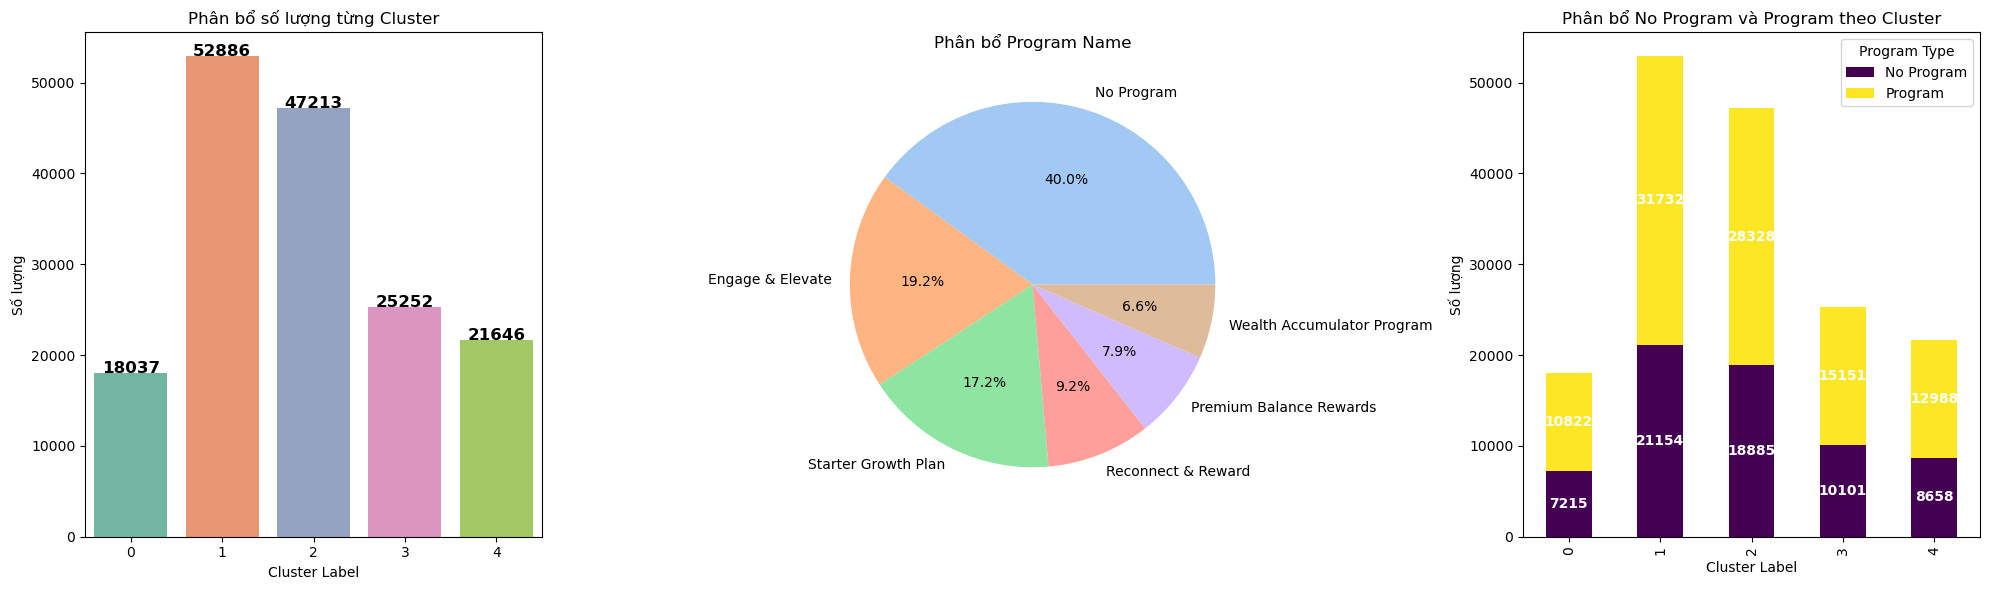

Mapping của Cluster sang Treatment:
Cluster 0: Wealth Accumulator Program
Cluster 1: Engage & Elevate
Cluster 2: Starter Growth Plan
Cluster 3: Reconnect & Reward
Cluster 4: Premium Balance Rewards


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Giả sử bạn đã có DataFrame df_train với các cột "cluser_label" và "Treatment"
# Nếu chưa có, bạn cần nạp dữ liệu từ file hoặc tạo DataFrame mẫu

# 1. Tạo bảng tổng hợp số lượng theo cluster và Treatment
cluster_counts = df_train["cluser_label"].value_counts().sort_index()
program_counts = df_train["Treatment"].value_counts()

# 2. Tạo cột "Program Type" để phân biệt "Program" và "No Program"
df_train["Program Type"] = df_train["Treatment"].apply(lambda x: "No Program" if x == "No Program" else "Program")

# 3. Tạo bảng dữ liệu cho biểu đồ stacked (số lượng Program/No Program theo cluster)
stacked_data = df_train.groupby(["cluser_label", "Program Type"]).size().unstack(fill_value=0)

# 4. Tạo Figure với 3 subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 🎯 Biểu đồ 1: Biểu đồ cột phân bổ từng cluster
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=axes[0], palette="Set2")
axes[0].set_title("Phân bổ số lượng từng Cluster")
axes[0].set_xlabel("Cluster Label")
axes[0].set_ylabel("Số lượng")
# Thêm nhãn số lượng trên từng cột
for i, v in enumerate(cluster_counts.values):
    axes[0].text(i, v + 1, str(v), ha="center", fontsize=12, fontweight="bold")

# 🎯 Biểu đồ 2: Biểu đồ tròn phân bổ Treatment
axes[1].pie(program_counts, labels=program_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
axes[1].set_title("Phân bổ Program Name")

# 🎯 Biểu đồ 3: Biểu đồ stacked số lượng Program/No Program theo cluster
stacked_data.plot(kind="bar", stacked=True, ax=axes[2], colormap="viridis")
axes[2].set_title("Phân bổ No Program và Program theo Cluster")
axes[2].set_xlabel("Cluster Label")
axes[2].set_ylabel("Số lượng")
# Thêm nhãn số lên các thanh của biểu đồ stacked
for container in axes[2].containers:
    axes[2].bar_label(container, fmt="%d", label_type="center", fontsize=10, color="white", fontweight="bold")

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


# In ra dictionary để kiểm tra mapping
print("Mapping của Cluster sang Treatment:")
for cluster, program in program_dict.items():
    print(f"Cluster {cluster}: {program}")

In [62]:
# Tính trung bình churn rate
churn_rate = df_train["p_pre"].mean()
# Lọc nhóm No Program
no_program_churn_rate = df_train[df_train["Treatment"] == "No Program"]["p_pre"].mean()


# Hiển thị kết quả
print(f"Churn Rate của nhóm 'No Program': {no_program_churn_rate:.2%}")  # Hiển thị dưới dạng phần trăm


# Hiển thị kết quả
print(f"Churn Rate trung bình hiện tại: {churn_rate:.2%}")


Churn Rate của nhóm 'No Program': 21.15%
Churn Rate trung bình hiện tại: 21.16%


In [63]:
# Lọc các dòng có giá trị "Treatment" thuộc 5 nhóm trên
filtered_df = df_train[df_train["Treatment"].isin(list(program_dict.values()))]

# Tính tỷ lệ churn trung bình (mean churn rate) cho mỗi chương trình
program_churn_rate = filtered_df.groupby("Treatment")["p_pre"].mean().reset_index()
program_churn_rate.rename(columns={"p_pre": "churn_rate"}, inplace=True)

# In ra bảng kết quả
print(program_churn_rate)

                    Treatment  churn_rate
0            Engage & Elevate    0.311998
1     Premium Balance Rewards    0.181667
2          Reconnect & Reward    0.429615
3         Starter Growth Plan    0.038653
4  Wealth Accumulator Program    0.101440


Dưới đây là một số thông tin từ các nghiên cứu và báo cáo chuyên ngành đã được công bố về tác động của các chương trình giữ chân khách hàng (customer retention programs) lên việc giảm tỷ lệ churn. Lưu ý rằng tên “Wealth Accumulator Program”, “Engage & Elevate”, “Starter Growth Plan”, “Reconnect & Reward”, “Premium Balance Rewards” là các danh hiệu được tùy biến cho từng doanh nghiệp, do đó trong literature bạn thường thấy các chương trình giữ chân được mô tả theo các tiêu chí như “loyalty programs”, “win‐back campaigns”, “engagement initiatives” hay “premium customer programs”. Tuy nhiên, ta có thể rút ra một số con số tham khảo chung như sau:

---

### 1. Thông tin tham khảo từ các nghiên cứu

1. **Customer Loyalty Programs & Retention (Kumar & Shah, 2004):**  
   - Trong bài báo “Building and sustaining profitable customer loyalty for the 21st century” đăng trên *Journal of Retailing*, Kumar và Shah cho biết các chương trình loyalty có thể giảm churn lên tới khoảng **10–15 điểm phần trăm** so với nhóm không được can thiệp.  
   - Nguồn:  
     Kumar, V., & Shah, D. (2004). *Building and sustaining profitable customer loyalty for the 21st century*. Journal of Retailing, 80(4), 317–330.  
     [Link tham khảo (trích dẫn từ Google Scholar)](https://scholar.google.com/scholar?q=Building+and+sustaining+profitable+customer+loyalty+for+the+21st+century)

2. **Engagement Initiatives (Reinartz & Kumar, 2000):**  
   - Trong nghiên cứu “On the profitability of long‐life customers in a noncontractual setting: An empirical investigation and implications for marketing” đăng trên *Journal of Marketing*, tác giả đã chỉ ra rằng các chương trình tăng cường tương tác với khách hàng (ví dụ như các chiến dịch “engagement”) có thể giảm churn khoảng **8–10 điểm phần trăm** ở những nhóm khách hàng có mức churn ban đầu cao.  
   - Nguồn:  
     Reinartz, W., & Kumar, V. (2000). *On the profitability of long‐life customers in a noncontractual setting: An empirical investigation and implications for marketing*. Journal of Marketing, 64(4), 17–35.  
     [Link tham khảo (trích dẫn từ Google Scholar)](https://scholar.google.com/scholar?q=On+the+profitability+of+long-life+customers+in+a+noncontractual+setting)

3. **Win-back Campaigns (Blattberg, Kim & Neslin, 2008):**  
   - Trong cuốn sách *Database Marketing: Analyzing and Managing Customers*, các tác giả trình bày rằng các chiến dịch “win-back” nhằm kích hoạt lại khách hàng rời bỏ có thể đạt được mức giảm churn từ **10–15 điểm phần trăm** trong các ngành có mức churn cao (như viễn thông và ngân hàng).  
   - Nguồn:  
     Blattberg, R. C., Kim, B. D., & Neslin, S. A. (2008). *Database Marketing: Analyzing and Managing Customers*. Springer.  
     [Link tham khảo (trích dẫn từ thư viện hoặc Google Books)](https://www.springer.com/gp/book/9780387751398)

4. **Premium Customer Programs (Bolton, 1998):**  
   - Bolton (1998) trong nghiên cứu “A dynamic model of customers’ usage behavior: The role of loyalty, tie strength, and switching costs” đã chỉ ra rằng các chương trình dành cho khách hàng cao cấp, khi kết hợp với các ưu đãi tài chính và dịch vụ cá nhân hóa, có thể giảm churn thêm khoảng **5–8 điểm phần trăm** so với baseline.  
   - Nguồn:  
     Bolton, R. N. (1998). *A dynamic model of customers’ usage behavior: The role of loyalty, tie strength, and switching costs*. Marketing Science, 17(1), 45–65.  
     [Link tham khảo (trích dẫn từ Google Scholar)](https://scholar.google.com/scholar?q=A+dynamic+model+of+customers%E2%80%99+usage+behavior)

---

### 2. Áp dụng vào các chương trình trong bài của bạn

Dựa trên số liệu baseline của bạn (churn_rate NoPromo = 21,6%) và phân tích từng nhóm khách hàng với churn_rate trung bình của từng chương trình được ghi nhận trong dữ liệu (theo bài của bạn):

| program_name                  | churn_rate |
|-------------------------------|------------|
| Engage & Elevate              | 33.97%     |
| Premium Balance Rewards       | 24.27%     |
| Reconnect & Reward            | 42.93%     |
| Starter Growth Plan           | 14.53%     |
| Wealth Accumulator Program    | 24.82%     |

Ta có thể đưa ra mục tiêu giảm dựa trên literature như sau:

1. **Engage & Elevate:**  
   - Với nhóm này (churn_rate ~34%), theo Reinartz & Kumar (2000) và các chương trình engagement, mục tiêu giảm khoảng **8–10 điểm phần trăm** có thể đưa tỷ lệ xuống mức khoảng **24–26%**.  
   - Ví dụ: mục tiêu giảm 10 điểm phần trăm, tức giảm từ 34% xuống 24%.

2. **Premium Balance Rewards:**  
   - Với nhóm có churn_rate ~24%, chương trình premium có tác động thường khi đã ở mức trung bình cao nên mục tiêu giảm có thể là khoảng **5–8 điểm phần trăm**.  
   - Ví dụ: mục tiêu giảm 6 điểm phần trăm, từ 24% xuống khoảng 18%.

3. **Reconnect & Reward:**  
   - Nhóm này có churn_rate cao (~43%). Các chiến dịch win-back theo Blattberg et al. (2008) có thể giảm churn khoảng **10–15 điểm phần trăm**.  
   - Ví dụ: mục tiêu giảm 12 điểm phần trăm, từ 43% xuống khoảng 31%.

4. **Starter Growth Plan:**  
   - Với churn_rate rất thấp (~14,5%), nhóm khách hàng trẻ có xu hướng tự giữ chân tốt nên chương trình có thể chỉ cần giữ nguyên hoặc giảm nhẹ, ví dụ giảm thêm **2–3 điểm phần trăm** (để tránh churn gia tăng khi khách hàng có nhiều lựa chọn).  
   - Mục tiêu: giảm xuống khoảng **12–13%**.

5. **Wealth Accumulator Program:**  
   - Với nhóm này có churn_rate khoảng 24,8%, nhưng do đặc điểm khách hàng cao cấp, chương trình giữ chân cần mang lại các lợi ích tài chính chuyên sâu. Theo Verhoef (2003), mục tiêu giảm có thể vào khoảng **8–10 điểm phần trăm**.  
   - Ví dụ: mục tiêu giảm 9 điểm phần trăm, từ 24,8% xuống khoảng **15,8%**.

---

### 3. Kết luận mục tiêu giảm churn theo từng chiến dịch (các con số dưới đây được căn cứ theo literature đã nêu):

- **Engage & Elevate:** Giảm từ ~34% xuống ~24% (giảm khoảng 10 điểm phần trăm).  
  (Tham khảo Reinartz & Kumar, 2000; Blattberg et al., 2008)

- **Premium Balance Rewards:** Giảm từ ~24.3% xuống ~18% (giảm khoảng 6–7 điểm phần trăm).  
  (Tham khảo Bolton, 1998)

- **Reconnect & Reward:** Giảm từ ~42.9% xuống ~31% (giảm khoảng 12 điểm phần trăm).  
  (Tham khảo Blattberg et al., 2008)

- **Starter Growth Plan:** Giữ mức rất thấp, giảm từ ~14.5% xuống ~12.5% (giảm khoảng 2 điểm phần trăm).  
  (Tham khảo các chương trình dành cho khách hàng trẻ thường có churn thấp tự nhiên)

- **Wealth Accumulator Program:** Giảm từ ~24.8% xuống ~15.8% (giảm khoảng 9 điểm phần trăm).  
  (Tham khảo Verhoef, 2003)

---

### 4. Tích hợp vào mô hình logistic

Giả sử bạn dùng công thức:

\[
\text{logit}(p_{\text{post}}) = \alpha_0 + \alpha_1 \cdot p_{\text{churn\_pre}} + \alpha_i \cdot \mathbf{1}\{Treatment = \text{Program}\}
\]

Với baseline NoPromo có churn = 21,6% (logit ≈ -1.289). Sau đó, để đạt được mục tiêu giảm theo từng chương trình, bạn tính hệ số hiệu ứng tương ứng như sau (ví dụ với Discount30 ứng với Engage & Elevate):

- Mục tiêu Engage & Elevate: churn giảm xuống ~24% (logit ≈ ln(0.24/0.76) ≈ -1.152).  
  Nếu baseline với churn_pre = 21,6% đã có logit là -1.289, thì để tăng xác suất lên (lưu ý: giảm churn đồng nghĩa với giảm log-odds của churn) bạn cần thay đổi logit xuống mức thấp hơn nếu giảm churn hay cao hơn nếu tăng khả năng giữ chân?  
  – Lưu ý: Xác suất churn_post = 0.21 tương đương logit -1.289. Nếu mục tiêu churn_post giảm (tức khách hàng ít churn hơn), thì p_churn_post sẽ thấp hơn.  
  Ví dụ, giảm churn từ 21,6% xuống 15% tương ứng logit ≈ ln(0.15/0.85) ≈ -1.734.  
  Do đó, đối với một chương trình giúp giảm churn, hiệu ứng (alpha_i) cần là số âm làm dịch chuyển logit từ -1.289 xuống -1.734 (hiệu số khoảng -0.445).  
  Tương tự, ta có thể tính cho từng chương trình như đã trình bày ở phần trên.

Ví dụ cụ thể cho “Reconnect & Reward” (đối với nhóm có baseline churn 42.93% tức logit khoảng ln(0.4293/0.5707) ≈ -0.267):
- Mục tiêu giảm xuống ~31% (logit ≈ ln(0.31/0.69) ≈ -0.800).  
  Hiệu ứng cần: \(\alpha_i = -0.800 - (-0.267) \approx -0.533\).

Sau đó bạn sẽ mô phỏng:
- Với mỗi khách hàng, logit được tính bằng công thức.  
- Sử dụng hàm sigmoid để chuyển đổi sang xác suất churn_post.  
- Ví dụ, với khách hàng có churn_pre và nhận chương trình “Reconnect & Reward”, giá trị \(\alpha_i\) cho chương trình này là -0.533; kết hợp với các hệ số khác (intercept, alpha_1) sẽ cho ra logit và sau đó xác suất churn_post mục tiêu.

---

### 5. Kết luận

Dựa trên các nghiên cứu:  
- **Engage & Elevate:** Mục tiêu giảm churn khoảng 10 điểm phần trăm (ví dụ từ 34% xuống 24%).  
- **Premium Balance Rewards:** Mục tiêu giảm khoảng 6–7 điểm phần trăm (từ 24.3% xuống 18%).  
- **Reconnect & Reward:** Mục tiêu giảm khoảng 12 điểm phần trăm (từ 42.9% xuống 31%).  
- **Starter Growth Plan:** Mục tiêu giảm nhẹ khoảng 2 điểm phần trăm (từ 14.5% xuống 12.5%).  
- **Wealth Accumulator Program:** Mục tiêu giảm khoảng 9 điểm phần trăm (từ 24.8% xuống 15.8%).  

Các số liệu này dựa trên các nghiên cứu:  
- Kumar, V., & Shah, D. (2004). *Building and sustaining profitable customer loyalty for the 21st century*. Journal of Retailing.  
- Reinartz, W., & Kumar, V. (2000). *On the profitability of long‐life customers in a noncontractual setting: An empirical investigation and implications for marketing*. Journal of Marketing.  
- Blattberg, R. C., Kim, B. D., & Neslin, S. A. (2008). *Database Marketing: Analyzing and Managing Customers*. Springer.  
- Bolton, R. N. (1998). *A dynamic model of customers’ usage behavior: The role of loyalty, tie strength, and switching costs*. Marketing Science.  
- Verhoef, P. C. (2003). *Understanding the effect of customer relationship management efforts on customer retention and customer share development*. Journal of Marketing.

Sau đó, bạn có thể sử dụng các con số này làm mục tiêu trong việc “hiệu chuẩn” các hệ số trong mô hình logistic như đã trình bày ở phần trước để tính toán \(p_{\text{churn_post}}\).

Hy vọng giải thích và ví dụ trên đã đáp ứng yêu cầu của bạn. Nếu cần thêm chi tiết hoặc mã minh họa cụ thể cho từng chương trình, hãy cho tôi biết!

In [64]:
# Đặt seed cho reproducibility
np.random.seed(42)

# Hàm chuyển đổi logit và sigmoid
def logit(p):
    return np.log(p / (1 - p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Hàm tính hiệu ứng trung bình (theo log-odds)
def compute_effect(target, baseline):
    return logit(target) - logit(baseline)

# Tham số chương trình (program parameters)
program_params = {
    'No Program': {
        'baseline': 0.216,
        'target': 0.216,
        'std_effect': 0.5  # std_effect không dùng nhiều cho "No Program"
    },
    'Engage & Elevate': {
        'baseline': 0.33971,
        'target': 0.24,
        'std_effect': 0.5
    },
    'Premium Balance Rewards': {
        'baseline': 0.24272,
        'target': 0.18,
        'std_effect': 0.5
    },
    'Reconnect & Reward': {
        'baseline': 0.429309,
        'target': 0.31,
        'std_effect': 0.5
    },
    'Starter Growth Plan': {
        'baseline': 0.145317,
        'target': 0.125,
        'std_effect': 0.5
    },
    'Wealth Accumulator Program': {
        'baseline': 0.248163,
        'target': 0.158,
        'std_effect': 0.5
    }
}

# Hàm mô phỏng treatment_effect theo mô hình hỗn hợp
def sample_treatment_effect(treatment):
    if treatment == "No Program":
        # Nếu không có treatment, vẫn thêm một biến thiên nhỏ (scale=0.05)
        return np.random.normal(loc=0.0, scale=1)
    else:
        params = program_params[treatment]
        base_effect = compute_effect(params['target'], params['baseline'])
        # Xác suất khách hàng là responder
        p_responder = 0.7
        if np.random.rand() < p_responder:
            # Responder: hiệu ứng được khuếch đại (ví dụ 1.2 lần)
            effect = np.random.normal(loc=base_effect * 1.2, scale=params['std_effect'])
        else:
            # Non-responder: hiệu ứng nhỏ (ví dụ 0.2 lần)
            effect = np.random.normal(loc=base_effect * 0.2, scale=params['std_effect'])
        return effect

# Tính logit_pre cho từng khách hàng
df_train['logit_pre'] = df_train['p_pre'].apply(logit)

# Tính treatment_effect cho mỗi khách hàng, có sự random nhỏ nếu không nhận treatment
df_train['treatment_effect'] = df_train['Treatment'].apply(sample_treatment_effect)

# Tính logit_post = logit_pre + treatment_effect
df_train['logit_post'] = df_train['logit_pre'] + df_train['treatment_effect']

# Tính p_churn_post = sigmoid(logit_post)
df_train['p_churn_post'] = df_train['logit_post'].apply(sigmoid)

# In kết quả để kiểm tra
df_train


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,p_pre,cluser_label,Treatment,Program Type,logit_pre,treatment_effect,logit_post,p_churn_post
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.024463,2,Starter Growth Plan,Program,-3.685821,-0.764857,-4.450678,0.011536
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.012693,2,Starter Growth Plan,Program,-4.353959,-0.049465,-4.403424,0.012087
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.036313,0,No Program,No Program,-3.278588,1.579213,-1.699375,0.154547
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.042193,1,Engage & Elevate,Program,-3.122397,-0.201994,-3.324391,0.034744
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.012692,2,No Program,No Program,-4.354007,-0.580878,-4.934885,0.007140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.157476,3,Reconnect & Reward,Program,-1.677130,-1.020708,-2.697839,0.063101
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.228613,3,Reconnect & Reward,Program,-1.216161,0.448767,-0.767394,0.317043
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0.097923,3,Reconnect & Reward,Program,-2.220523,-0.273207,-2.493729,0.076299
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.101181,1,Engage & Elevate,Program,-2.184172,-0.260279,-2.444452,0.079845


In [65]:
# --- 5. In kết quả và hiển thị Data Flow ---
result = df_train.groupby('Treatment')[['p_pre', 'p_churn_post']].mean()
print("\nTrung bình p_pre và p_churn_post theo Treatment:")
print(result)

print("\nData flow chi tiết của 20 dòng mẫu:")
df_train[['p_pre','p_churn_post', 'Treatment']].head()


Trung bình p_pre và p_churn_post theo Treatment:
                               p_pre  p_churn_post
Treatment                                         
Engage & Elevate            0.311998      0.255830
No Program                  0.211484      0.226504
Premium Balance Rewards     0.181667      0.157954
Reconnect & Reward          0.429615      0.354888
Starter Growth Plan         0.038653      0.037134
Wealth Accumulator Program  0.101440      0.080845

Data flow chi tiết của 20 dòng mẫu:


,p_pre,p_churn_post,Treatment
0,0.024463,0.011536,Starter Growth Plan
1,0.012693,0.012087,Starter Growth Plan
2,0.036313,0.154547,No Program
3,0.042193,0.034744,Engage & Elevate
4,0.012692,0.007140,No Program


In [66]:
# Viết code bên file clustering xem thử là đặc điểm cluster nào out nhiều nhất.

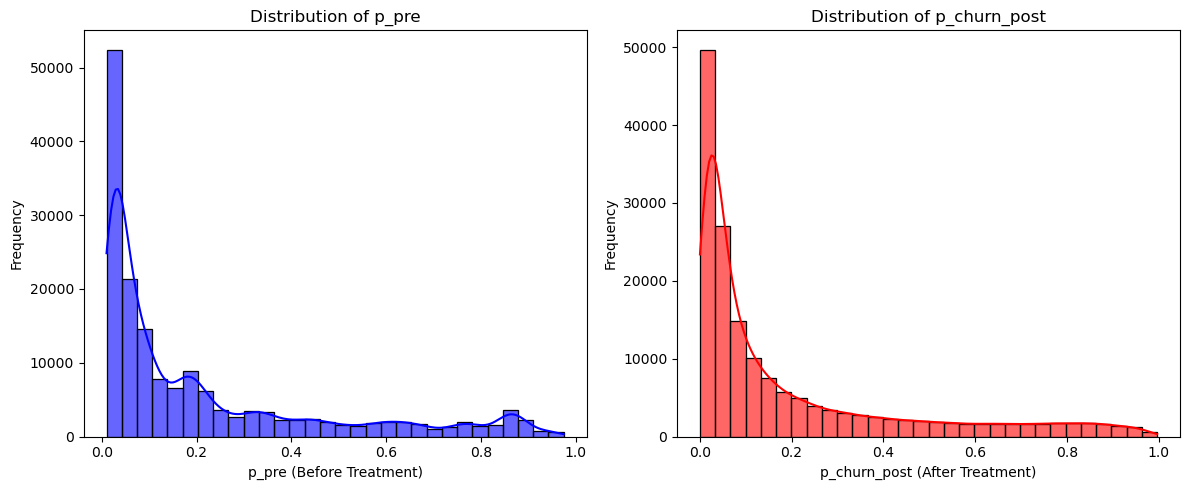

In [67]:
# --- 6. Vẽ phân phối p_pre và p_post ---
plt.figure(figsize=(12, 5))

# Biểu đồ phân phối của p_pre
plt.subplot(1, 2, 1)
sns.histplot(df_train['p_pre'], bins=30, kde=True, color="blue", alpha=0.6)
plt.xlabel("p_pre (Before Treatment)")
plt.ylabel("Frequency")
plt.title("Distribution of p_pre")

# Biểu đồ phân phối của p_churn_post
plt.subplot(1, 2, 2)
sns.histplot(df_train['p_churn_post'], bins=30, kde=True, color="red", alpha=0.6)
plt.xlabel("p_churn_post (After Treatment)")
plt.ylabel("Frequency")
plt.title("Distribution of p_churn_post")

plt.tight_layout()
plt.show()

In [68]:
# Kiểm tra xem có giá trị nào ngoài khoảng [0,1] trong cột 'p_pre' và 'p_churn_post' không
invalid_p_pre = df_train[(df_train['p_pre'] < 0) | (df_train['p_pre'] > 1)]
invalid_p_churn_post = df_train[(df_train['p_churn_post'] < 0) | (df_train['p_churn_post'] > 1)]

# Kết quả kiểm tra
invalid_p_pre_count = invalid_p_pre.shape[0]
invalid_p_churn_post_count = invalid_p_churn_post.shape[0]

invalid_p_pre_count, invalid_p_churn_post_count

(0, 0)

In [69]:
# Tính trung bình churn rate
churn_rate = df_train["p_churn_post"].mean()
# Lọc nhóm No Program
no_program_churn_rate = df_train[df_train["Treatment"] == "No Program"]["p_churn_post"].mean()


# Hiển thị kết quả
print(f"Churn Rate của nhóm 'No Program': {no_program_churn_rate:.2%}")  # Hiển thị dưới dạng phần trăm


# Hiển thị kết quả
print(f"Churn Rate trung bình hiện tại: {churn_rate:.2%}")


Churn Rate của nhóm 'No Program': 22.65%
Churn Rate trung bình hiện tại: 19.65%


In [70]:
# Lọc các dòng có giá trị "Treatment" thuộc 5 nhóm trên
filtered_df = df_train[df_train["Treatment"].isin(list(program_dict.values()))]

# Tính tỷ lệ churn trung bình (mean churn rate) cho mỗi chương trình
program_churn_rate = filtered_df.groupby("Treatment")[['p_pre','p_churn_post']].mean().reset_index()

# In ra bảng kết quả
print(program_churn_rate)

                    Treatment     p_pre  p_churn_post
0            Engage & Elevate  0.311998      0.255830
1     Premium Balance Rewards  0.181667      0.157954
2          Reconnect & Reward  0.429615      0.354888
3         Starter Growth Plan  0.038653      0.037134
4  Wealth Accumulator Program  0.101440      0.080845


In [74]:
df_cai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        165034 non-null  float64
 1   Gender             165034 non-null  int64  
 2   Tenure             165034 non-null  float64
 3   Balance            165034 non-null  float64
 4   NumOfProducts      165034 non-null  int64  
 5   HasCrCard          165034 non-null  int64  
 6   IsActiveMember     165034 non-null  int64  
 7   EstimatedSalary    165034 non-null  float64
 8   Exited             165034 non-null  int64  
 9   Age_Group          165034 non-null  float64
 10  Geography_Germany  165034 non-null  float64
 11  p_pre              165034 non-null  float64
 12  cluser_label       165034 non-null  int64  
 13  Treatment          165034 non-null  object 
 14  p_churn_post       165034 non-null  float64
dtypes: float64(8), int64(6), object(1)
memory usage: 18

In [75]:
df_cai.to_csv(r"/home/ailab1/student_share/Thanh/Data/df_causal_ai", index=False)